##### 2状態準線形モデルにおける、時間反復法(time iteration method)による数値解法

以下の準線形モデルを解く

\begin{align*}
    y_{t} &= E_{t}y_{t+1} - (r_{n,t}-E_{t}\pi_{t+1}-s_{t}),\\
    \pi_{t} &= \beta E_{t}\pi_{t+1} + \kappa y_{t},\\
    r_{n,t}^{*} &= r^{*} + \phi_{\pi} E_{t}\pi_{t+1},\\
    r_{n,t} &= \max \{r_{n,t}^{*} ,0\}.
\end{align*}

$s_t\in\{s_{H},s_{L}\}$は以下の遷移行列を持つマルコフ連鎖に従う
\begin{align*}
    P = \left[\begin{array}{cc}
    1-p_{H} & p_{H}\\
    1-p_{L} & p_{L}
    \end{array}\right].
\end{align*}


In [1]:
using Optim
using Plots

In [2]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    rstar::TF   # pH=0のときの、定常状態での名目金利の値
    bet::TF     # 割引率
    phi::TF     # テイラー係数
    kap::TF     # フィリップス曲線の傾き
    sH::TF      # 状態Hでの自然利子率の値
    sL::TF      # 状態Lでの自然利子率の値
    pH::TF      # 危機が起こる確率
    pL::TF      # 危機の継続確率
    maxiter::TI # 繰り返し回数の最大値
    tol::TF     # 許容誤差
end

In [3]:
# カリブレーションに用いる関数
function dist(x0,rstar,bet,phi,sH,pH,pL,yLtar,piLtar)

    sL = x0[1]
    kap = x0[2]

    # 解析的解
    A = [-1+(1-pH) pH -(phi-1)*(1-pH) -(phi-1)*pH;
        kap 0 -1+bet*(1-pH) bet*pH;
        (1-pL) -1+pL (1-pL) pL;
        0 kap bet*(1-pL) -1+bet*pL]
    b = [rstar-sH;0;-sL;0]
    x = A\b
    #yH  = x(1);
    yL  = x[2]
    #piH = x(3);
    piL = x[4]

    # データの値とモデルの値の間の距離を最小化
    f = (yL-yLtar)^2 + (piL-piLtar)^2

    return f
    
end

dist (generic function with 1 method)

In [4]:
# time iterationを行う関数
function ti(m)

    ## STEP 1(a): グリッド生成
    Gs = [m.sH; m.sL]
    Ps = [1.0-m.pH m.pH; 
        1.0-m.pL m.pL]
    
    # 解析的解
    A = [-1+(1-m.pH) m.pH -(m.phi-1)*(1-m.pH) -(m.phi-1)*m.pH;
    m.kap 0 -1+m.bet*(1-m.pH) m.bet*m.pH;
    (1-m.pL) -1+m.pL (1-m.pL) m.pL;
    0 m.kap m.bet*(1-m.pL) -1+m.bet*m.pL]
    b = [m.rstar-m.sH;0;-m.sL;0]
    x = A\b
    yH  = x[1]
    yL  = x[2]
    piH = x[3]
    piL = x[4]
    rH = m.rstar + m.phi*((1-m.pH)*piH + m.pH*piL)

    ## STEP 1(b): 政策関数の初期値を当て推量
    Ns = 2
    # 解析的解を初期値とする(1回の繰り返しで収束)
    yvec0 = [yH; yL]
    pvec0 = [piH; piL]
    rvec0 = [rH; 0]
    # 適当な初期値
    #yvec0 = zeros(Ns)
    #pvec0 = zeros(Ns)
    #rvec0 = zeros(Ns)
    yvec1 = zeros(Ns)
    pvec1 = zeros(Ns)
    rvec1 = zeros(Ns)
    
    ## STEP 4: 政策関数を繰り返し計算
    diff = 1e+4
    iter = 1

    while(diff > m.tol)

#         # next period's pfs are initialized here
#         yvec1 = zeros(Float64,Ns,1)
#         pvec1 = zeros(Float64,Ns,1)
#         rvec1 = zeros(Float64,Ns,1)
        
        ## STEP 3: 各グリッドごとに最適化
        for is = 1:Ns

            # ショックの値
            s0 = Gs[is]

            # 古い政策関数から期待値(ye,pie)を計算
            ye = Ps[is,1]*yvec0[1] + Ps[is,2]*yvec0[2]
            pie = Ps[is,1]*pvec0[1] + Ps[is,2]*pvec0[2]

            # 期待値を所与として(y0,pi0,i0)を計算
            r0 = max(m.rstar + m.phi*pie, 0)
            y0 = ye - (r0 - pie - s0)
            pi0 = m.kap*y0 + m.bet*pie

            # 新しい政策関数を保存
            yvec1[is] = y0
            pvec1[is] = pi0
            rvec1[is] = r0

        end
        
        # 繰り返し計算誤差を確認
        ydiff = maximum(abs.(yvec1-yvec0))
        pdiff = maximum(abs.(pvec1-pvec0))
        rdiff = maximum(abs.(rvec1-rvec0))
        diff = maximum([ydiff pdiff rdiff])

        println([iter diff])

        # 政策関数をアップデート
        yvec0 = copy(yvec1)
        pvec0 = copy(pvec1)
        rvec0 = copy(rvec1)
        
        iter = iter + 1

    end
    
    return yvec0, pvec0, rvec0
    
end

ti (generic function with 1 method)

In [6]:
# Juliaにおいて、関数の外に書かれる変数はすべてグローバル変数（関数の中からもアクセスできる）

rstar = 0.75 # pH=0のときの、定常状態での名目金利の値
bet = 1/(1+rstar/100) # 割引率(オイラー方程式の定常状態より)
phi = 5.0  # テイラー係数(注: 小さいとiL=0にならない)
pL = 0.75  # 危機の継続確率
sH = rstar # 状態Hでの自然利子率の値

# カリブレーション
# yLとpiLのターゲットにpH=0のときのモデルの値を合わせるように、sLとkapの値をセット

pH = 0.0 # 危機が起こる確率
x0 = [-2.0, 0.01] # sLとkapの初期値

# yLとpiLのターゲット
yLtar = -7.0
piLtar = -1.0/4

# 最小化関数(Juliaの場合NelderMead())を用いる
dist!(x0) = dist(x0,rstar,bet,phi,sH,pH,pL,yLtar,piLtar)
res = optimize(dist!,x0,NelderMead())

# カリブレートしたパラメータをセット
sL = res.minimizer[1]  # 状態Lでの自然利子率の値
kap = res.minimizer[2] # フィリップス曲線の傾き


maxiter = 2000 # 繰り返し回数の最大値
tol = 1e-5 # 許容誤差

# 構造体にパラメータを格納
m = Model(rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol)

Model{Int64,Float64}(0.75, 0.9925558312655086, 5.0, 0.00912668190392673, 0.75, -1.5625167241936313, 0.0, 0.75, 2000, 1.0e-5)

In [7]:
@time yvec0, pvec0, rvec0 = ti(m)

[1.0 2.77556e-17]
  0.528472 seconds (1.52 M allocations: 75.873 MiB, 4.94% gc time)


([-8.88178e-16, -6.99996], [-8.10612e-18, -0.249963], [0.75, 0.0])

In [8]:
pH = 0.025
m = Model(rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol)

@time yvec1, pvec1, rvec1 = ti(m)

[1.0 8.88178e-16]
  0.000362 seconds (158 allocations: 7.797 KiB)


([0.596622, -6.50083], [-0.0385837, -0.2696], [0.528205, 0.0])

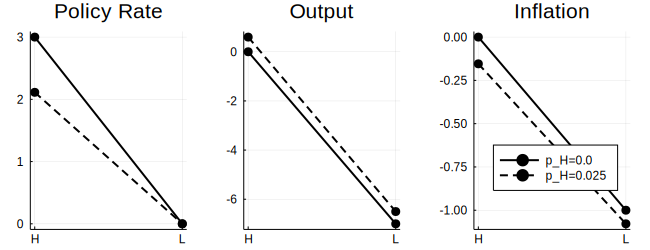

In [65]:
x1 = [1 2; 1 2]
x2 = x1
x3 = x1
y1 = [rvec0'*4; rvec1'*4]
y2 = [yvec0'; yvec1']
y3 = [pvec0'*4; pvec1'*4]
cl = [:black :black]
ls = [:solid :dash]
# lw = [2 2]
# msh = [:circle :circle]
# msz = [4 4]

plot(
    plot(x1',y1',title="Policy Rate",color=cl,linestyle=ls,legend=false), #,markershape=msh,markersize=msz),
    plot(x2',y2',title="Output",color=cl,linestyle=ls,legend=false), #,markershape=msh,markersize=msz),
    plot(x3',y3',title="Inflation",color=cl,linestyle=ls,legend=:bottomleft,label=["p_H=0.0" "p_H=0.025"]), #,linewidth=lw,color=cl,markershape=msh,markersize=msz),
    layout=(1,3),size=(650,250),linewidth=2,markershape=:circle,markersize=4,xticks=([1 2],["H" "L"])
)